## Plot elevation of spatial domain with LFM observation locations
Last updated: Kevin Varga, 12/30/2024

**Inputs:**
* Netcdf of elevation
* CSV of locations of LFM observations
* Shapefile of county boundaries

**Outputs:**
* Map of elevation
* Map of CA with elevation domain inset

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader

In [2]:
# Set paths
lf_path = '/home/sbarc/students/varga/nasa/data/landfire/'
obs_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_obs/'
shp_path = '/home/sbarc/students/varga/nasa/data/shapefiles/'
output_path = '/home/sbarc/students/varga/nasa/ch1/figures/lfm_maps/'

In [3]:
# Open elevation data array
elev_da = xr.open_dataarray(lf_path + 'elevation.nc')
# Read in csv that contains lat/lon of observation sites
obs_df = pd.read_csv(obs_path + 'lfm_crop_site_loc.csv', index_col='site')

In [4]:
# Read in county shapefile
counties_shp = cfeature.ShapelyFeature(shpreader.Reader(shp_path + 'ca_counties.shp').geometries(),
                                       ccrs.PlateCarree(), edgecolor='black', facecolor='none')

In [5]:
# Create class to adjust value to use for sea level in terrain colormap
class FixPointNormalize(mcolors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [6]:
# Combine the lower and upper range of the terrain colormap with a gap in the middle
# to let the coastline appear more prominently.
# inspired by https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 56))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200))
# combine them and build a new colormap
colors = np.vstack((colors_undersea, colors_land))
cut_terrain_map = mcolors.LinearSegmentedColormap.from_list('cut_terrain', colors)

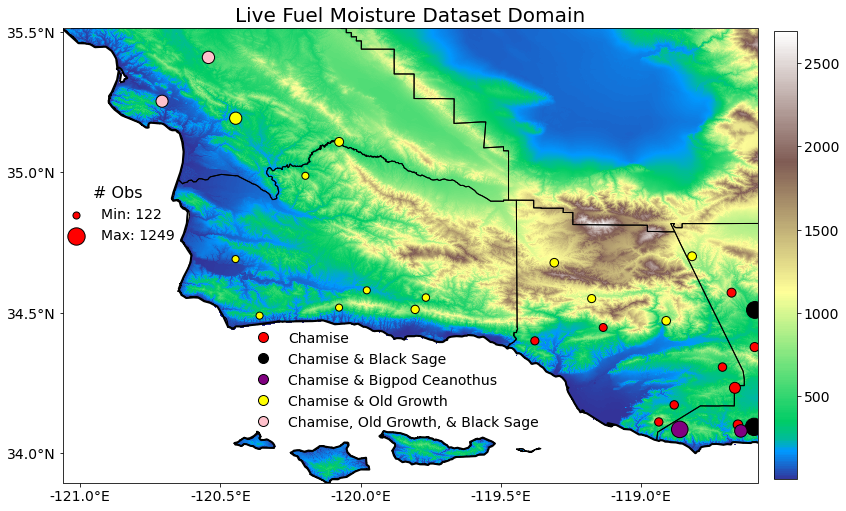

In [ ]:
# Define color mapping and naming for fuel combinations
fuel_colors = {
    "['chamise']": 'red',
    "['sage_black', 'chamise']": 'black',
    "['ceanothus_bigpod', 'chamise']": 'purple',
    "['chamise_old_growth', 'chamise']": 'yellow',
    "['sage_black', 'chamise_old_growth', 'chamise']": 'pink'
}

combo_labels = ['Chamise','Chamise & Black Sage', 'Chamise & Bigpod Ceanothus',
                'Chamise & Old Growth', 'Chamise, Old Growth, & Black Sage']

# Scale n_obs to reasonable marker sizes (adjust these values as needed)
min_size, max_size = 50, 300
obs_df['marker_size'] = np.interp(obs_df['n_obs'], 
                                 (obs_df['n_obs'].min(), obs_df['n_obs'].max()), 
                                 (min_size, max_size))

# Extract latitude and longitude values and set extent
lon = elev_da['longitude'].values
lat = elev_da['latitude'].values
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

# Create tick mark values
lon_ticks = [-119, -119.5, -120, -120.5, -121]
lat_ticks = [34, 34.5, 35, 35.5]

# Create figure
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and county lines
ax.coastlines(lw=2)
ax.add_feature(counties_shp, zorder=1)

# Create terrain normalization level
norm = FixPointNormalize(sealevel=250, vmax=elev_da.max())

# Create map of elevation data
im = ax.imshow(elev_da, cmap='terrain', norm=norm, origin='lower', extent=extent,
               transform=ccrs.PlateCarree(), interpolation='none')

# Plot LFM observation locations with different colors and sizes
for i, fuel_combo in enumerate(fuel_colors):
    subset = obs_df[obs_df['fuel'] == fuel_combo]
    ax.scatter(subset['longitude'], subset['latitude'], 
              s=subset['marker_size'], 
              c=fuel_colors[fuel_combo],
              marker='o',  # Changed to circle for better size visibility
              transform=ccrs.PlateCarree(),
              label=combo_labels[i],
              edgecolors='black', linewidths=1,
              zorder=5) 

# Add the latitude and longitude tickmarks
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{l:.1f}°E' for l in lon_ticks], fontsize=14)
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{l:.1f}°N' for l in lat_ticks], fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, pad=0.02, shrink=0.55, orientation='vertical')
cbar.ax.tick_params(labelsize=14)

# Create custom handles for the fuel type legend to ensure same size markers
fuel_handles = []
for i, fuel_combo in enumerate(fuel_colors):
    fuel_handles.append(plt.Line2D([0], [0], marker='o', color='none', 
                                  markerfacecolor=fuel_colors[fuel_combo],
                                  markeredgecolor='black',
                                  markersize=10,  # Fixed size for all legend markers
                                  label=combo_labels[i]))

# Add legend for fuel types with custom handles
legend1 = ax.legend(handles=fuel_handles, 
                   fontsize=14, 
                   loc='lower left', 
                   bbox_to_anchor=(0.25, 0.09),
                   frameon=False)

# Add a second legend for size reference
size_legend_elements = [
    plt.scatter([], [], s=min_size, c='red', label=f'Min: {obs_df["n_obs"].min()}', edgecolors='black', linewidths=1),
    plt.scatter([], [], s=max_size, c='red', label=f'Max: {obs_df["n_obs"].max()}', edgecolors='black', linewidths=1)
]
legend2 = ax.legend(handles=size_legend_elements, 
                   fontsize=14, 
                   loc='lower left', 
                   bbox_to_anchor=(-0.02, 0.5),
                   title='# Obs',
                   title_fontsize=16,
                   frameon=False)

# Add both legends to the plot
ax.add_artist(legend1)

# Add title
plt.title('Live Fuel Moisture Dataset Domain', fontsize=20)

plt.show()
fig.savefig(output_path + 'elevation.png',
            dpi = 600, bbox_inches='tight');

### Plot map of CA with elevation inset

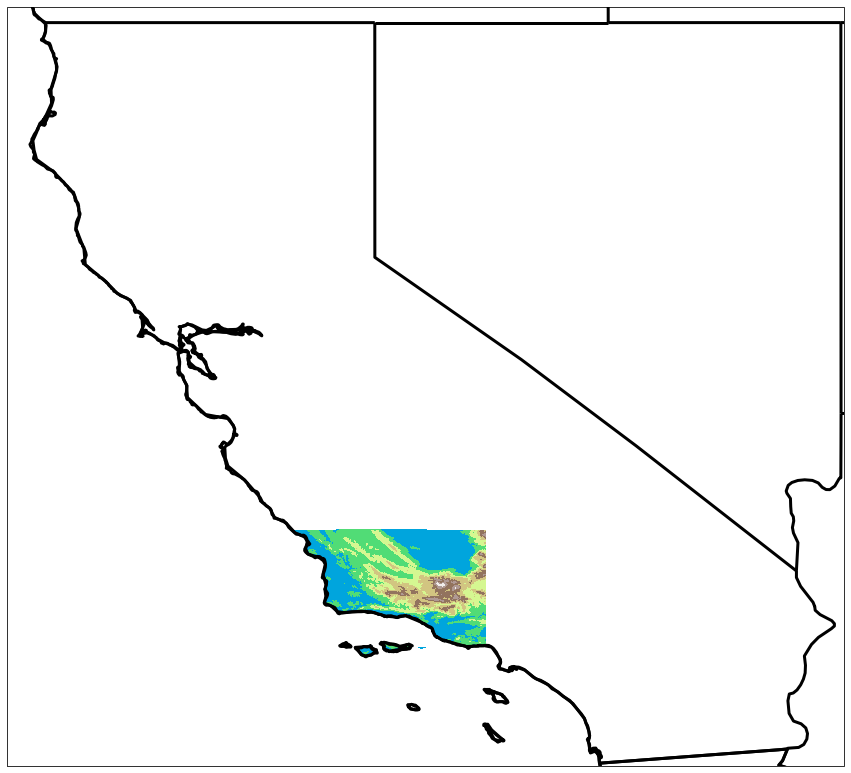

In [54]:
extent = [-124.7, -114, 32.5, 42.2]

# Add state boundaries
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# Add country borders
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')

# Create figure
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)
# Add coastline and borders
ax.coastlines(lw=3)
ax.add_feature(states_provinces, edgecolor='black', linewidth=3)
ax.add_feature(countries, edgecolor='black', linewidth=3)

# Create terrain normalization level
norm = FixPointNormalize(sealevel=250, vmax=data.max())

# Create map of elevation data
# Ensure origin is in the lower left and set interpolation to 'none'
#im = ax.imshow(elev_da, cmap='terrain', norm=norm, origin='lower', extent=extent,
#               transform=ccrs.PlateCarree(), interpolation='none')

# Plot elevation values
im = plt.contourf(elev_da['longitude'], elev_da['latitude'], elev_da, 
                  transform=ccrs.PlateCarree(), cmap='terrain', norm=norm)
plt.show()